### Simulating Airnode behavior during Black Thursday
We look at how Airnode would have behaved during Black Thursday (March 12). Specifically, how much lag time would Airnode responses have had if we used the gas price selection technique of: randomly selecting a txn from the most recently mined block and using that gas price. I'll call this method RAND1 for short. I did some more general analysis in this other notebook here: https://github.com/sassmilic/historical-gas-prices/blob/master/gas-price-predictions.ipynb but this notebook specifically is meant to look at how RAND1 would behave in an outlier-like scenerio (e.g. Black Thursday).

### Assumptions
- Given an Ethereum block $B$, let the minimum gas price of any transaction in that block be $p_{min}$. We assume that *if* there had been a txn $x$ in the mempool (at roughly the time $B$ was mined) and that the gas cost of $x$ was *strictly greater* than $p_{min}$, then $x$ would have been included and mined in $B$.
    - Is this a good assumption? It's hard to say since the set of transactions mined in a given block is non deterministic, although definitely skewed toward the transactions with highest gas price. Truly evaluting the viability of this assumption would require a historical analysis of mem pool data, which is arguably impossible since the mem pool isn't actually recorded on the blockchain (mem pool txns are yet to be mined). Another way to test this is doing so live, on the blockchain itself; i.e. test run Airnode with RAND1 and see how it performs.
     
### Model setup
- We model Airnode operating continuously throughout the period between March 11 - March 13 (i.e. around the time of Black Thursday)
- Airnode is required to respond every minute.
- Airnode processes requests in parallel, so we can treat (i.e. model) responding to one request the same as responding to multiple.
- We model *success* as the Airnode's response being mined in $\le$ 1 minute.

In [1]:
# Imports
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# suppresses annoying SettingWithCopyWarning
pd.options.mode.chained_assignment = None
import random
import seaborn as sns

import _airnode_sim_utils

In [2]:
# aesthetics
sns.set_style("white")
sns.set_style("ticks", {
    "xtick.major.size": 7,
    "ytick.major.size": 7}
)
sns.axes_style("white")  

API3_PURPLE = '#7963B2'
API3_EMERALD = '#7CE3CB'

# helper functions
to_date_str = lambda ts: datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

## Get historical transaction data

In [3]:
file_patterns = [
    '../gas_prices_2020-03-11_2020-03-13_100%-sampling*',
]

df = _airnode_sim_utils.load_data(file_patterns)
df

255 total files.


,blockNum,timeStamp,txnID,gasPrice
0,9646854,1583884773,0x1eb4d0a5e7702cf65d4a2e49743989cfc39a005d7d70...,40.000
1,9646854,1583884773,0x1906edf9ba5a06ad9870910892b4a34bc1d2fe3885ef...,10.000
2,9646854,1583884773,0xd9867d0d23048a0a7afa255c411597aac87dde6b7c58...,10.000
3,9646854,1583884773,0x0ce33d9fd0a59f3b9d8fe16c51c24bd5f1eea6b9f479...,10.000
4,9646854,1583884773,0x6e27c8fe7fa22d438e635e7085d0f971ee4e0438638d...,12.000
...,...,...,...,...
1463433,9659732,1584056274,0x48dc681c49bf30bf7ad9dc955bb04030abbeca63334b...,79.807
1463434,9659732,1584056274,0xfde22c0f31c6c1ff1c53b527140afba33fb406623352...,79.300
1463435,9659732,1584056274,0xfb440ec55301b67de1e4f8b8d4508578d7da1745cbe2...,81.000
1463436,9659732,1584056274,0xb04e41616d87dc3438a2a4c2f222f56ce8a1cc123817...,72.000


In [4]:
start_ts = df.iloc[0]['timeStamp']
end_ts = df.iloc[-1]['timeStamp']

print("PRECISE DATE RANGE")
print(f"Start:\t{to_date_str(start_ts)}")
print(f"End:\t{to_date_str(end_ts)}")

PRECISE DATE RANGE
Start:	2020-03-10 23:59:33
End:	2020-03-12 23:37:54


# Visualizing historical gas prices

In [5]:
df2 = df # in order to preserve the same df throughout; i.e. not modified

In [6]:
# group per hour
to_hour = lambda ts: datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H')
df2['hour'] = df.timeStamp.apply(to_hour)

# drop hour with little data (right before March 11)
df2 = df2[df2['hour'] != '2020-03-10 23']

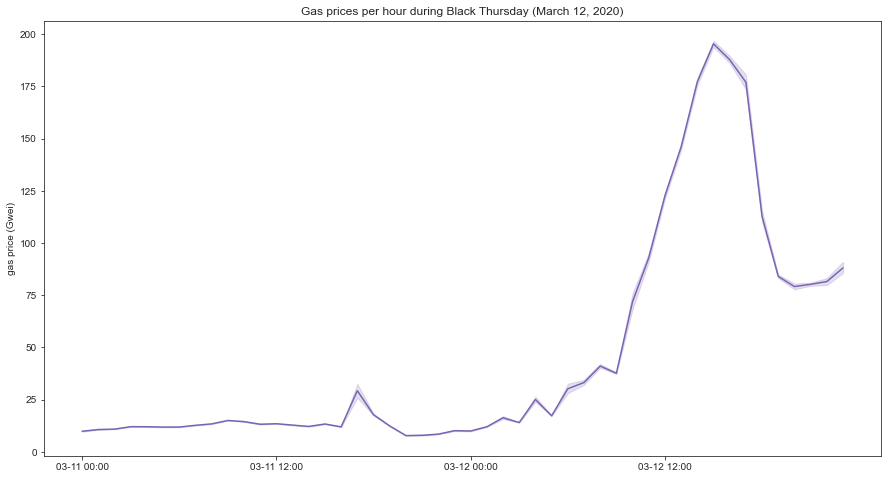

In [7]:
_, ax = plt.subplots(1, 1, figsize=(15,8))

g = sns.lineplot(data=df2, x='hour', y='gasPrice', color=API3_PURPLE)

hours = list(df2.hour.unique())
g.set_xticks([hours[i] for i in range(0, len(hours), 12)])
g.set_xticklabels([hours[i][5:] + ':00' for i in range(0, len(hours), 12)])
g.set(xlabel='', ylabel='gas price (Gwei)')

#plt.xticks(rotation=45)

g.set_title('Gas prices per hour during Black Thursday (March 12, 2020)');

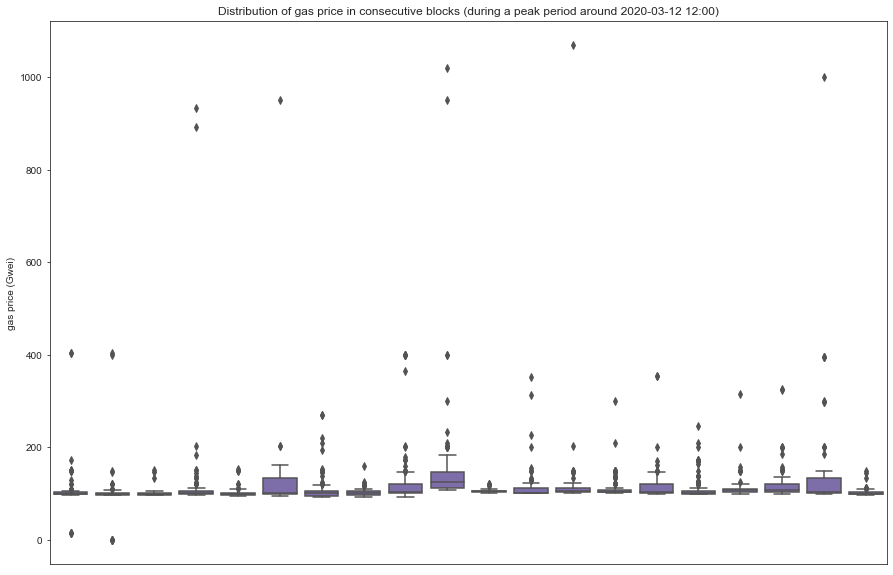

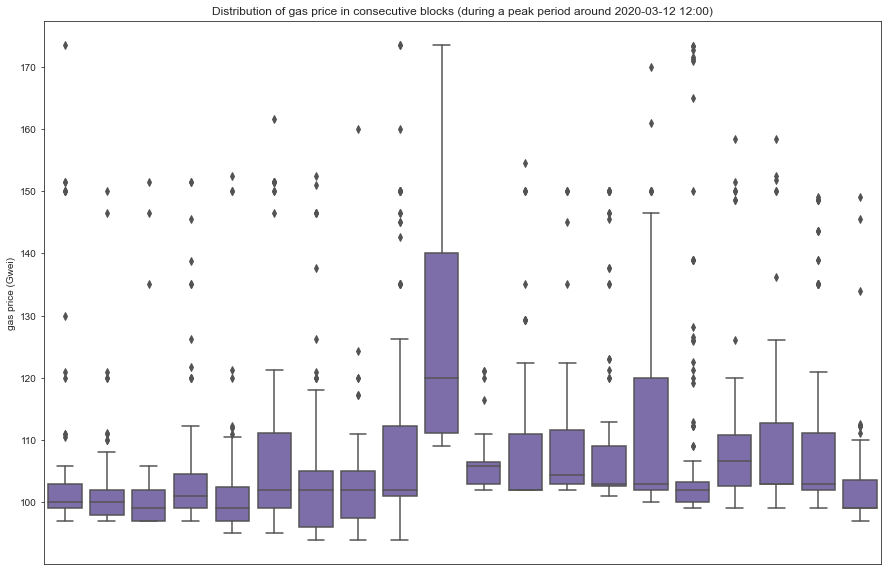

In [8]:
_airnode_sim_utils.plot1(df)
_airnode_sim_utils.plot1(df, lower_cap=75, upper_cap=175)

# Modeling Airnode behaviour
1. Airnode wakes up every minute
    * We assume it always has requests, and thus must make a transaction every minute.  
2. It checks the most recently mined block.
3. It randomly selects a txn from that block.
4. The gas price of that txn is selected as the price of Airnode's current txn.
    * TODO: mitigate against selecting an extreme gas price (e.g. frontrunning txns)

In [9]:
# We randomly select when the Airnode starts running.
# To ensure enough historical blocks to compute recommended gas price, 
# we start 5 minutes after our historical data starts.
airnode_start_ts = df.iloc[0]['timeStamp'] + random.randint(5 * 60, 6 * 60)
print(f'Airnode start time: {to_date_str(airnode_start_ts)}')

Airnode start time: 2020-03-11 00:04:36


In [13]:
airnode_wake_up_times = range(airnode_start_ts, df.iloc[-1]['timeStamp'] - 60, 60)

In [14]:
###
### See sim code in: ./_airnode_sim_utils.py
###
df_results = _airnode_sim_utils.airnode_sim(df, airnode_wake_up_times)
df_results

,wakeup_ts,gasPrice,mined?
0,1583885076,8.000000,True
1,1583885136,5.000000,True
2,1583885196,8.000000,True
3,1583885256,18.000000,True
4,1583885316,6.000000,True
...,...,...,...
2848,1584055956,97.500000,True
2849,1584056016,78.000000,True
2850,1584056076,100.650002,True
2851,1584056136,87.828405,True


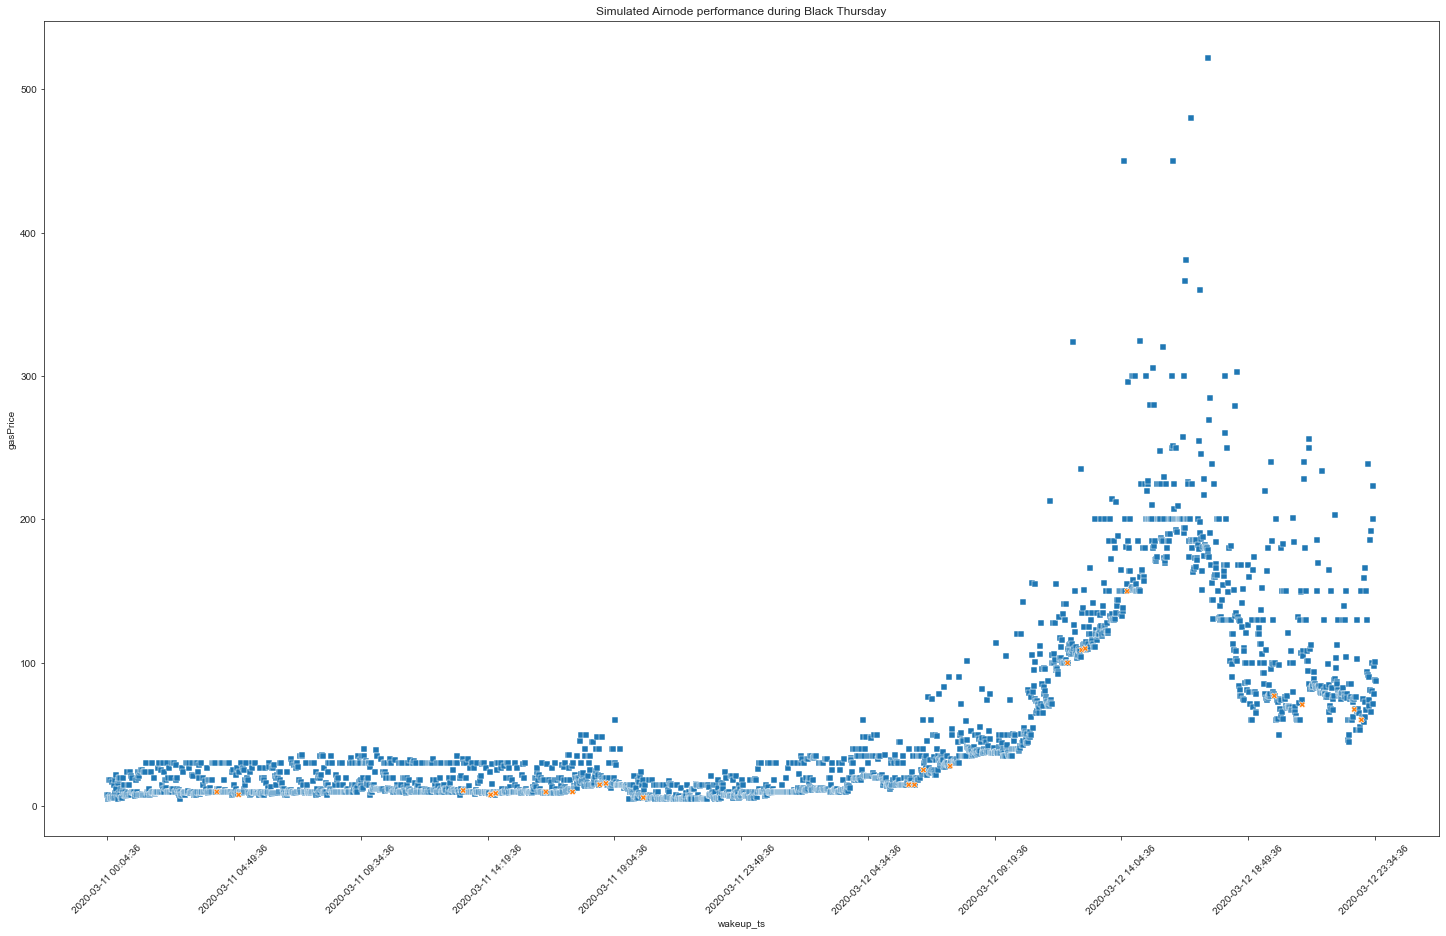

In [16]:
def plot2(df):
    _, ax = plt.subplots(1, 1, figsize=(25,15))
    
    markers = {False: "X", True: "s"}

    sns.scatterplot(data=df[df['mined?']],
                    x="wakeup_ts", y="gasPrice",
                    palette=["#2ec4b6"],
                    style="mined?", markers=markers,
                    legend=False
    )
    
    sns.scatterplot(data=df[~df['mined?']],
                    x="wakeup_ts", y="gasPrice",
                    palette=["#e71d36"],
                    style="mined?", markers=markers,
                    legend=False
    )

    n = len(df['wakeup_ts'])
    ticks = [df['wakeup_ts'][i] for i in range(0, n, n // 10)]
    plt.xticks(ticks, [to_date_str(x) for x in ticks]);
    plt.xticks(rotation=45);
    plt.title('Simulated Airnode performance during Black Thursday')
    
    
plot2(df_results)

### Comments
- In general, performance seems pretty good.
- Clearly, we need a way to filter extreme values in a smart way.
- As expected, failed transactions have gas prices that are quite low.

## What's the longest lag time? I.e. what's the maximum # of minutes we wait to get mined?

In [18]:
blocks = (df_results != df_results.shift()).cumsum()
block_ranges = blocks.groupby('mined?', group_keys=False).apply(lambda x: (x.index[0], x.index[-1]))

df2 = pd.DataFrame(block_ranges, columns=["range"]).reset_index().drop(columns=['mined?'])
df2['mined?'] = df2["range"].apply(lambda x: df_results.loc[x[0]]['mined?'])
df2['length'] = df2["range"].apply(lambda x: x[1] - x[0] + 1)
#df2 = df2[df2['mined?'] == False]
#df2.groupby('length').count()
df_success = df2[df2['mined?']]
successes = df_success.sum()['length']

df_fail = df2[~df2['mined?']]
df_fail['count'] = [True] * df_fail.shape[0]
df_fail = df_fail.groupby('length').sum()['count']

length = [0, 1, 2]
df_lag = pd.DataFrame({
    'length': length,
    'count': [successes] + [df_fail.loc[i] for i in length[1:]]
})
df_lag

,length,count
0,0,2829
1,1,20
2,2,2


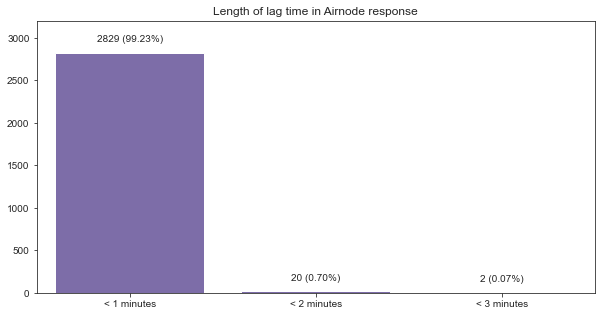

In [20]:
_, ax = plt.subplots(1, 1, figsize=(10,5))
g = sns.barplot(x="length", y="count", data=df_lag, color=API3_PURPLE);
g.set(ylim=(0, 3200))
g.set_xticklabels([f'< {x} minutes' for x in range(1, 4)])
g.set(xlabel='', ylabel='')

sum_ = sum(p.get_height() for p in g.patches)

for p in g.patches:
    g.annotate(
        f"{p.get_height():.0f} ({(100 * p.get_height() / sum_):.2f}%)",
        (p.get_x() + p.get_width() / 2., p.get_height() + 50),
        ha = 'center', va = 'center',
        xytext = (0, 9),
        textcoords = 'offset points')
    
g.set_title('Length of lag time in Airnode response');

### Comments
- 99.23% of the time, the Airnode "succeeds" — that is, it gets mined in a block within a minute (before it "wakes up" again).
- In the absolute worst case (in our simulation), there are two examples where the Airnode lags ~3 minutes — that is, it fails to get mined *2 times in a row*.

### TODO

- Implement something that prevents extreme gas prices being selected from previous block.